In [8]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import albumentations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets

In [9]:
class Model(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1)
        self.conv2 = nn.Conv2d(16, 64, 3, 2, 1)
        self.fc = nn.LazyLinear(num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [10]:
class MNIST(datasets.MNIST):
    def __init__(self, root: str, train: bool = True, transform = None, download: bool = False) -> None:
        super().__init__(root=root, train=train, transform=transform, download=download)
    
    def __getitem__(self, index: int):
        image, label = self.data[index], self.targets[index]
        
        if self.transform is not None:
            transform = self.transform(image=image.unsqueeze(2).numpy())
            image = transform["image"]
            
        return image, label

In [11]:
transform = albumentations.Compose([
    albumentations.Normalize(mean=0, std=1),
    albumentations.Blur(blur_limit=4),
    ToTensorV2()
])

In [12]:
config = {
    "epoch": 30,
    "batch_size": 32,
    "lr": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
}

In [13]:
mnist_train = MNIST(root='../../data/', train=True, transform=transform, download=True)
mnist_valid = MNIST(root='../../data/', train=False, transform=transform, download=True)
train_data = DataLoader(mnist_train, config["batch_size"], shuffle=True)
valid_data = DataLoader(mnist_valid, config["batch_size"])

In [14]:
model = Model(10).to(config["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), config["lr"])

In [83]:
total_train = {
    "loss": [],
    "acc": [],
}
total_valid = {
    "loss": [],
    "acc": [],
}
for i in range(1, config["epoch"] + 1):
    model.train()
    train_acc = []
    train_loss = []
    for image, label in train_data:
        image, label = image.to(config["device"]), label.to(config["device"])

        pred = model(image)
        loss = criterion(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_acc.append((pred.max(1)[1] == label).float().mean().item())

    with torch.no_grad():
        model.eval()
        valid_acc = []
        valid_loss = []
        for image, label in valid_data:
            image, label = image.to(config["device"]), label.to(config["device"])

            pred = model(image)
            loss = criterion(pred, label)
            
            valid_loss.append(loss.item())
            valid_acc.append((pred.max(1)[1] == label).float().mean().item())
    
    total_train["loss"].append(np.mean(train_loss))
    total_train["acc"].append(np.mean(train_acc))
    total_valid["loss"].append(np.mean(valid_loss))
    total_valid["acc"].append(np.mean(valid_acc))
    
    if i % 10 == 0:
        print(f"epoch: {i}/{config['epoch']}")
        print(f"acc".ljust(5), f"train: {np.mean(train_acc):.3f}, valid: {np.mean(valid_acc):.3f}")
        print(f"loss".ljust(5), f"train: {np.mean(train_loss):.3f}, valid: {np.mean(valid_loss):.3f}")

epoch: 10/30
acc   train: 0.968, valid: 0.985
loss  train: 0.107, valid: 0.047
epoch: 20/30
acc   train: 0.972, valid: 0.986
loss  train: 0.094, valid: 0.043
epoch: 30/30
acc   train: 0.973, valid: 0.986
loss  train: 0.087, valid: 0.042


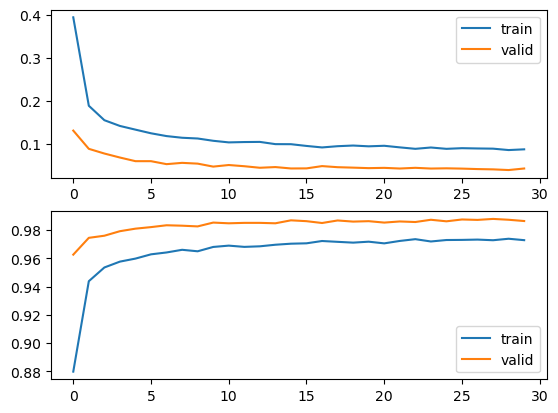

In [84]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(np.arange(config["epoch"]), total_train["loss"], label="train")
ax[0].plot(np.arange(config["epoch"]), total_valid["loss"], label="valid")
ax[0].legend()
ax[1].plot(np.arange(config["epoch"]), total_train["acc"], label="train")
ax[1].plot(np.arange(config["epoch"]), total_valid["acc"], label="valid")
ax[1].legend()
plt.show()